In [76]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
from copy import deepcopy
import random
from time import perf_counter

In [77]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [78]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [79]:
#broj grana koje su tacno obojene
def calculate_value(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

In [80]:
def initialize(graph):
    return [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]

In [81]:
def shaking(graph, coloring, k):
    new_coloring = deepcopy(coloring)
    chosen_indices = random.sample(range(len(coloring)), k)

    for idx in chosen_indices:
        new_coloring[idx] = random.randrange(1, len(graph.edges()))
    
    return new_coloring

In [82]:
def local_search_invert_first_improvement(graph, coloring, value, iter):
    
    new_coloring = deepcopy(coloring)
    improved = True
    best_iter = iter

    while improved:

        iter += 1
        improved = False
        unbiased_order = list(range(len(new_coloring)))
        random.shuffle(unbiased_order)

        for i in unbiased_order:
            old = new_coloring[i]
            new_coloring[i] = random.randrange(len(graph.edges))
            new_value = calculate_value(graph, new_coloring)

            if new_value < value:
                value = new_value
                improved = True
                best_iter = iter
                break
            else:
                new_coloring[i] = old
                
    return new_coloring, value, best_iter

In [83]:
def vns(graph, vns_params: dict):
    start_time = perf_counter()
    coloring = initialize(graph)
    value = calculate_value(graph, coloring)
    iter = 0

    while perf_counter() - start_time < vns_params['time_limit']:
        for k in range(vns_params['k_min'], vns_params['k_max']):
            
            new_coloring = shaking(graph, coloring, k)
            new_value = calculate_value(graph, new_coloring)

            new_coloring, new_value, iter_local = local_search_invert_first_improvement(graph, new_coloring, new_value, iter) # intensification
            
            iter = iter_local

            if new_value < value or (new_value == value and random.random() < vns_params['move_prob']):
                if is_valid_coloring(graph, new_coloring):
                    value = new_value
                    coloring = deepcopy(new_coloring)

    return coloring, iter

In [84]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [85]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [86]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts[1] = int(parts[1]) if len(parts) > 1 else 0
    return parts

In [87]:
vns_params = {
    'time_limit': 2,
    'k_min': 1,
    'k_max': 2,
    'move_prob': 0.5,
}

In [88]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):
    with open('./results/vns_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [89]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")
            
            start_time = time.time()
            graph = read_graph_from_file(filepath)
            coloring_result, iter = vns(graph, vns_params)
            end_time = time.time()
            
            write_output(graph, file, coloring_result, iter, start_time, end_time)         

Running test graph_3_edges.txt...


Minimum edge coloring found.
Number of colors: 3
Number of iterations: 2900


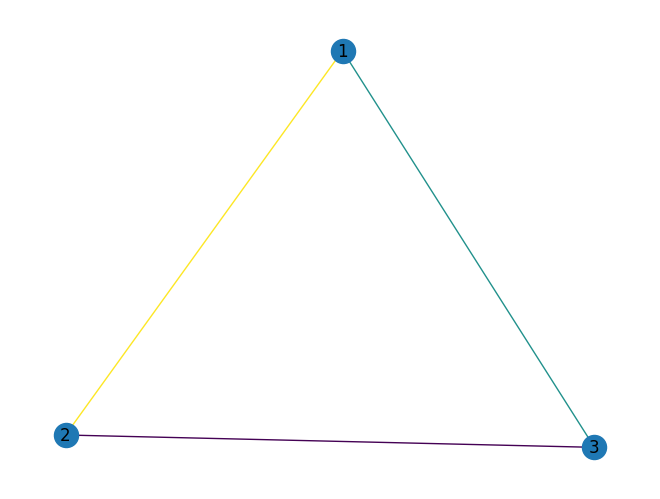

Time taken: 1.9993438720703125 seconds

Running test graph_5_edges.txt...
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 1260


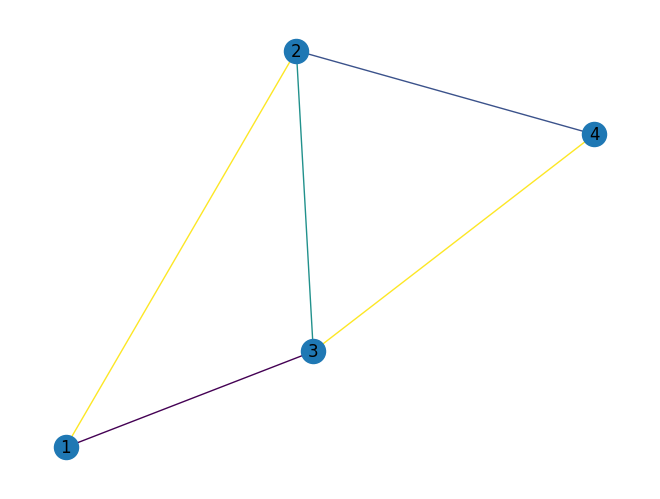

Time taken: 1.99607515335083 seconds

Running test graph_5_edges_2.txt...
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 1475


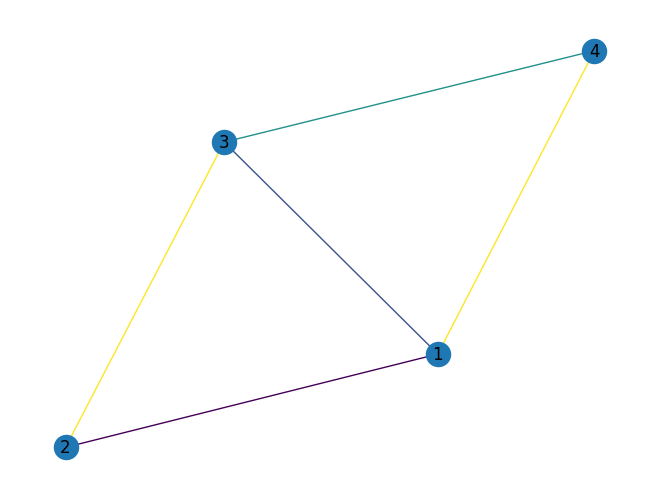

Time taken: 1.9982900619506836 seconds

Running test graph_6_edges.txt...
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 750


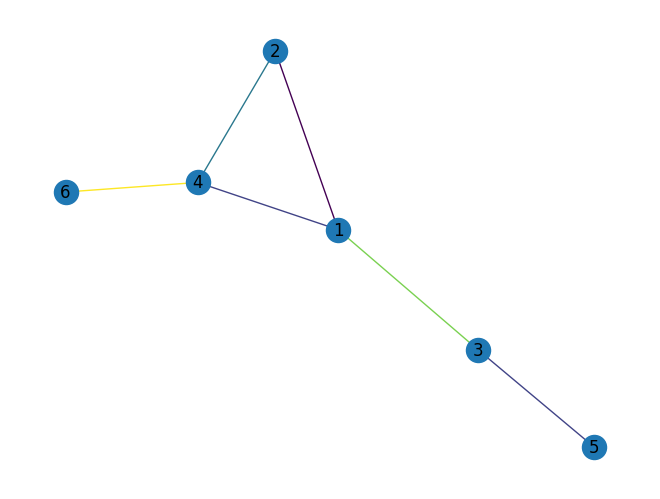

Time taken: 1.9974162578582764 seconds

Running test graph_7_edges.txt...
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 903


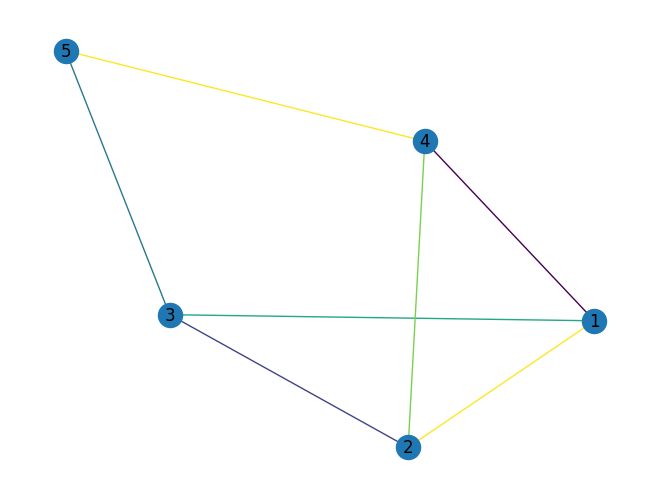

Time taken: 1.9983911514282227 seconds

Running test graph_7_edges_2.txt...
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 979


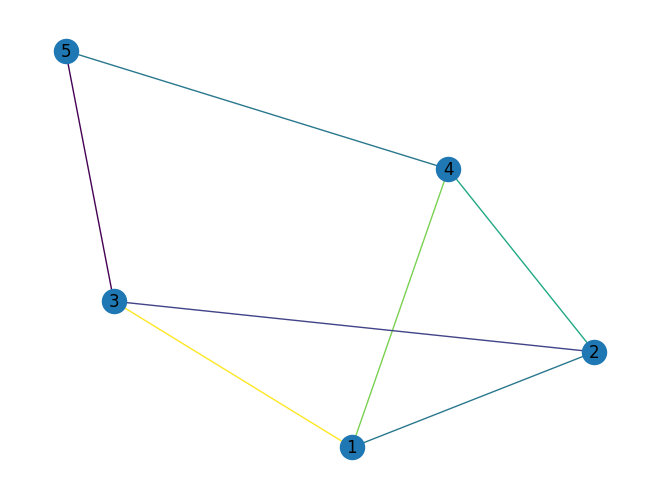

Time taken: 2.001067876815796 seconds

Running test graph_7_edges_3.txt...
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 586


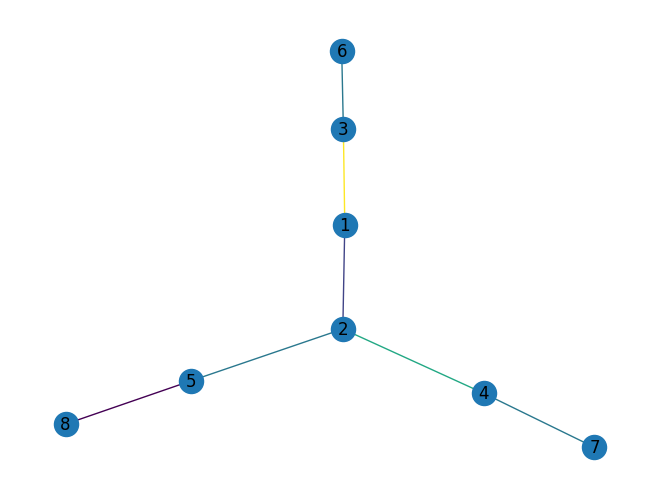

Time taken: 1.9999091625213623 seconds

Running test graph_8_edges.txt...
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 358


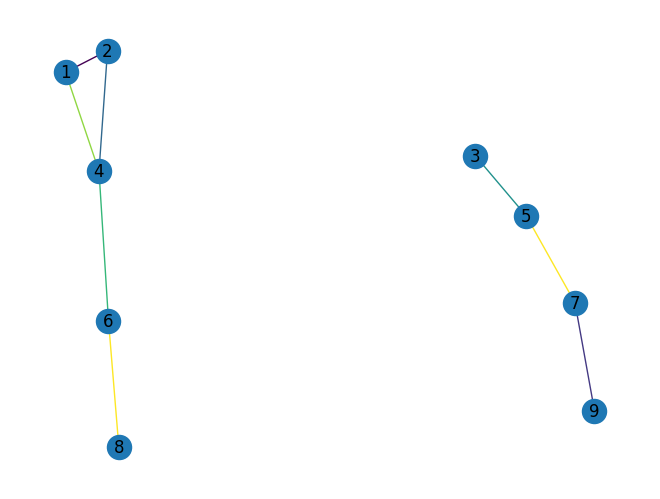

Time taken: 2.0011889934539795 seconds

Running test graph_9_edges.txt...
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 442


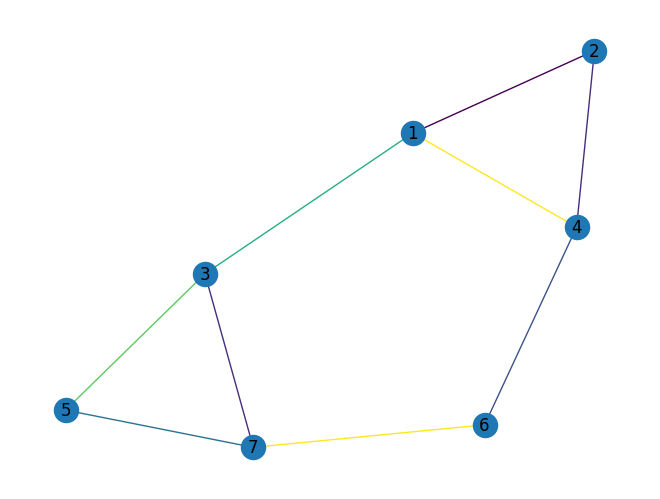

Time taken: 2.0018062591552734 seconds

Running test graph_9_edges_2.txt...
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 294


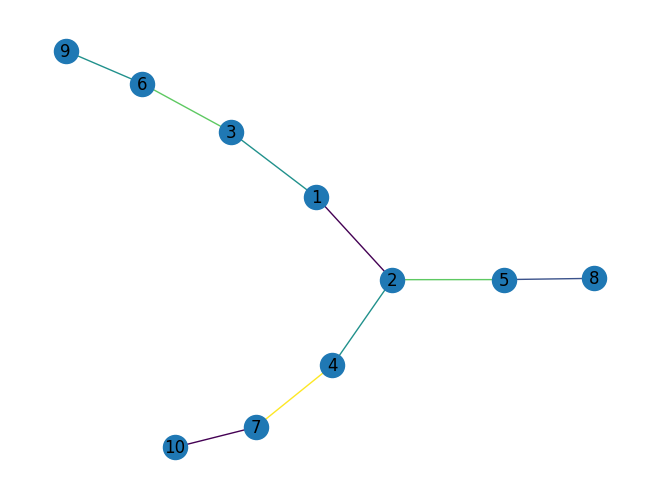

Time taken: 2.000044584274292 seconds

Running test graph_10_edges.txt...
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 185


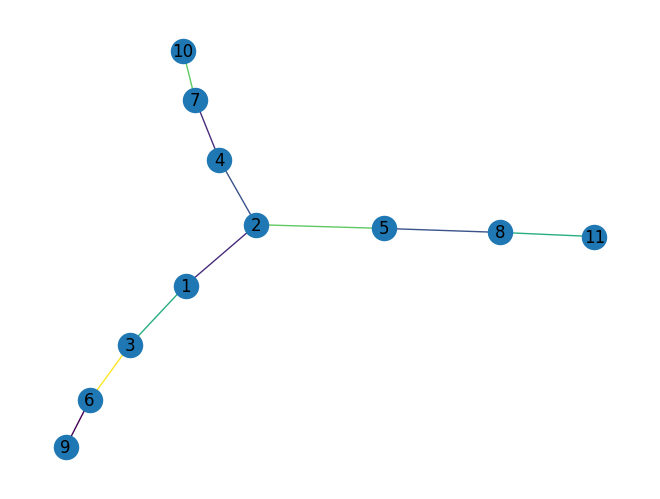

Time taken: 2.0035274028778076 seconds

Running test graph_10_edges_2.txt...
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 335


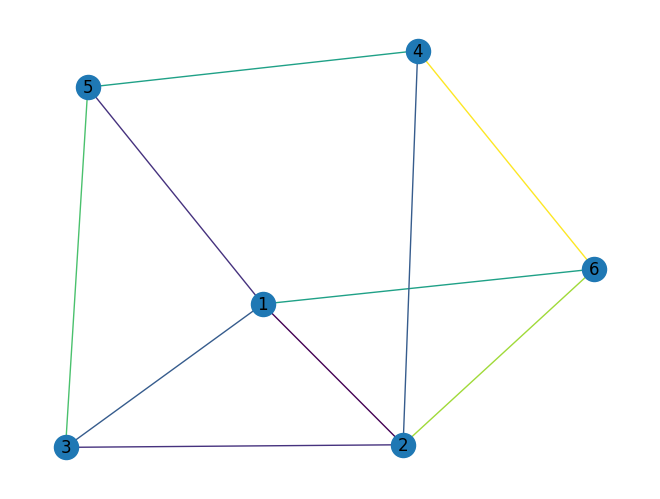

Time taken: 1.997427225112915 seconds

Running test graph_10_edges_3.txt...
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 161


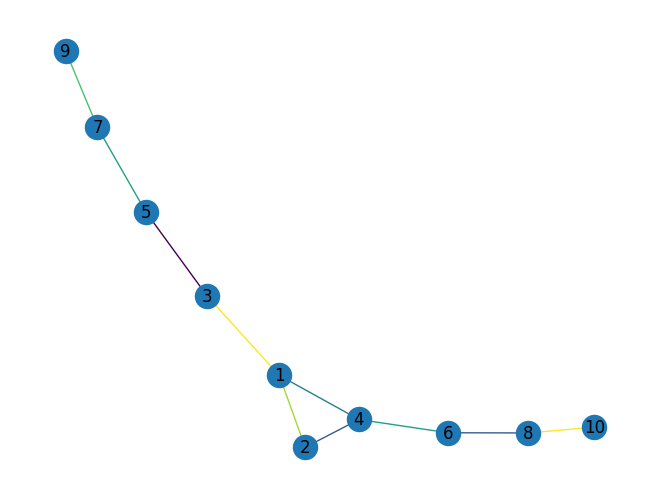

Time taken: 1.9924213886260986 seconds

Running test graph_11_edges.txt...
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 278


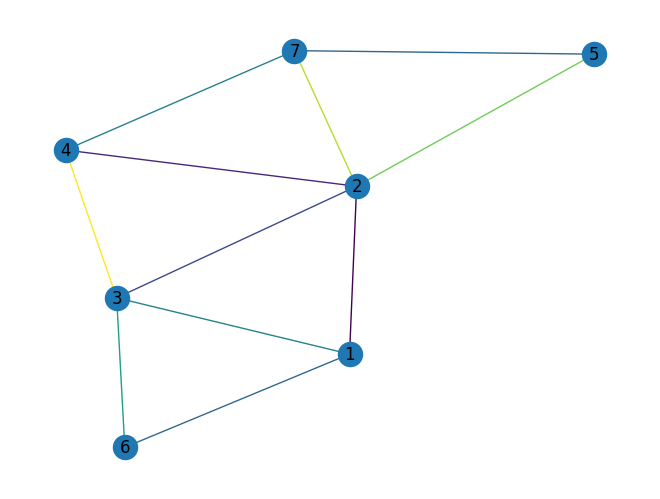

Time taken: 2.005603075027466 seconds

Running test graph_11_edges_2s.txt...
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 269


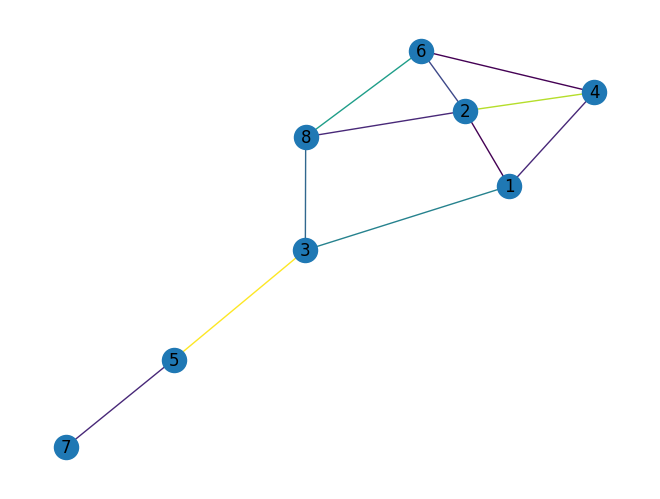

Time taken: 2.0026516914367676 seconds

Running test graph_11_edges_3.txt...
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 140


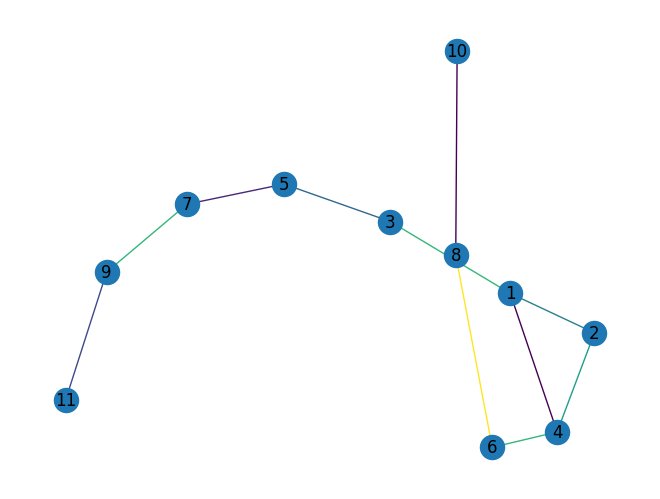

Time taken: 2.0011935234069824 seconds

Running test graph_11_edges_4.txt...
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 121


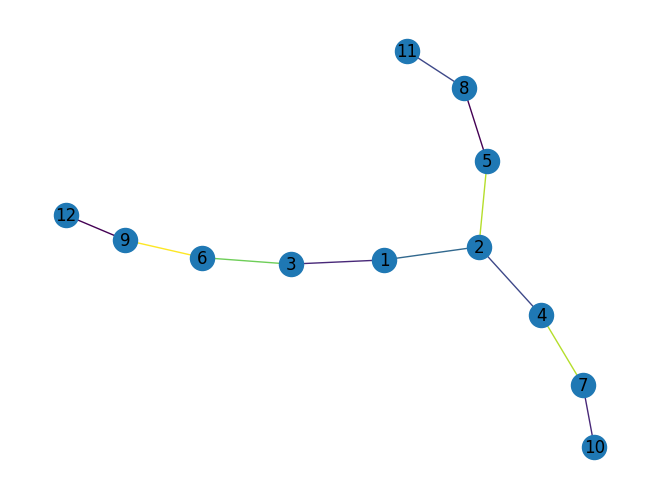

Time taken: 2.003976583480835 seconds

Running test graph_12_edges.txt...
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 97


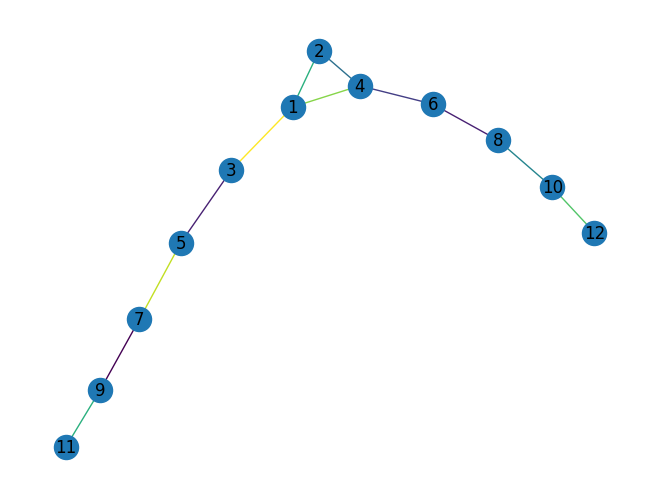

Time taken: 2.000992774963379 seconds

Running test graph_12_edges_2.txt...
Minimum edge coloring found.
Number of colors: 11
Number of iterations: 71


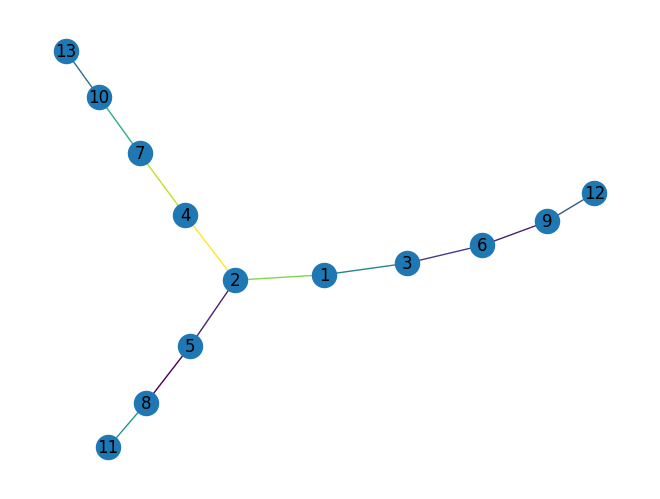

Time taken: 2.0033602714538574 seconds

Running test graph_15_edges.txt...
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 84


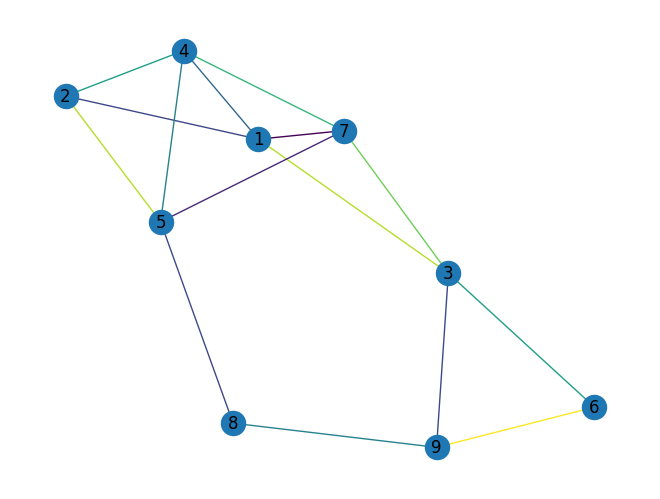

Time taken: 2.0054574012756348 seconds



In [90]:
run_tests('./tests')